In [1]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat_ws, collect_set, year, weekofyear, col
import itertools
import pickle
from collections import Counter
import pickle
import os
from pyspark.sql.types import ArrayType, StringType

from pyspark.sql import Row

from functools import reduce
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import explode, size, udf

try:
    spark.stop()
except:
    pass

# Start session
spark = (
    SparkSession.builder
      .appName("WiClean+_FPgrowth")
      .master("spark://spark:7077")

      .config("spark.driver.memory",       "4g")
      .config("spark.executor.memory",     "42g")

      .config("spark.driver.maxResultSize","0")

      .config("spark.sql.shuffle.partitions","300")
      .config("spark.default.parallelism",  "300")

      .config("spark.serializer",           "org.apache.spark.serializer.KryoSerializer")
      .config("spark.kryoserializer.buffer.max","1g")
      .getOrCreate()
)

spark.range(5).show()




25/04/28 21:40:48 WARN Utils: Your hostname, hyperbola resolves to a loopback address: 127.0.1.1; using 192.168.0.66 instead (on interface enp6s0)
25/04/28 21:40:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/28 21:40:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+



In [2]:
#Load the full events
events = spark.read.parquet("data/events.parquet")

# load the top-10k meaningful typed pages
top10k = spark.read.parquet("data/top10k_typed_pages.parquet")

# filter events to only those involving top10k src_articles
events_top10k = events.join(top10k, events.src_article == top10k.article_id)

# add week column (year-week) and item description
# with fancy arrows :)
tx_small = (events_top10k.withColumn("week", concat_ws("-", year("timestamp"), weekofyear("timestamp")))
                          .withColumn("item", concat_ws("→", col("action"), col("src_article"), col("dst_article")))
                          .groupBy("src_article", "week")
                          .agg(collect_set("item").alias("items")))

# Save transactions
tx_small.write.mode("overwrite").parquet("data/transactions_small.parquet")

print(f"Transactions built: {tx_small.count():,} article-week transactions")
tx_small.show(5, truncate=False)



25/04/28 21:40:57 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 98.06% for 31 writers
25/04/28 21:40:57 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 95.00% for 32 writers
25/04/28 21:40:57 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 98.06% for 31 writers


Transactions built: 237,263 article-week transactions


25/04/28 21:41:01 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-----------+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|src_article|week   |items                                                                                                                                                                                                                                                                                                 |
+-----------+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|34         |2024-52|[+→34→47578, -→34→534780]   

In [4]:
# Note: this cell will take super long to execute
# and takes a ton of memory. I don't recommend
# waiting for it during grading.

# reload total number of transactions
tx_small = spark.read.parquet("data/transactions_small.parquet")
total_tx = tx_small.count()

print(f" Total transactions: {total_tx:,}")

# set batch size
batch_size = 20000
num_batches = (total_tx // batch_size) + 1

print(f" Will split into {num_batches} batches (each with ~{batch_size} transactions)")

for batch_idx in range(num_batches):
    # load a slice
    batch = (tx_small
             .limit((batch_idx+1) * batch_size)
             .subtract(tx_small.limit(batch_idx * batch_size))
             .select("items")
             .rdd.map(lambda r: r.items)
             .collect())

    # count pairs in batch
    batch_counter = Counter()

    for items in batch:
        if items is None or len(items) < 2:
            continue
        sorted_items = sorted(items)
        pairs = itertools.combinations(sorted_items, 2)
        batch_counter.update(pairs)

    # save batch counter to file
    with open(f"data/pair_counts_batch_{batch_idx}.pkl", "wb") as f:
        pickle.dump(batch_counter, f)

    print(f" Processed and saved batch {batch_idx+1}/{num_batches}")

final_counter = Counter()

for batch_idx in range(2): # had to reduce the number of batches merged for memory reasons
    with open(f"data/pair_counts_batch_{batch_idx}.pkl", "rb") as f:
        batch_counter = pickle.load(f)
    final_counter.update(batch_counter)

# get top-20 pairs
top20_pairs = final_counter.most_common(20)

print("\n=== Top-20 frequent link pairs ===")
for pair, count in top20_pairs:
    print(f"{pair}: {count} transactions")



 Total transactions: 237,263
 Will split into 12 batches (each with ~20000 transactions)

=== Top-20 frequent link pairs ===
('+→29990→770424', '-→29990→770424'): 6 transactions
('-→179793→115059', '-→179793→2438627'): 6 transactions
('-→867603→158010', '-→867603→2780152'): 6 transactions
('-→867603→158010', '-→867603→650907'): 6 transactions
('-→867603→2780152', '-→867603→650907'): 6 transactions
('+→4028906→33091', '+→4028906→6328'): 6 transactions
('+→4028906→33091', '-→4028906→33091'): 6 transactions
('+→4028906→33091', '-→4028906→6328'): 6 transactions
('+→4028906→6328', '-→4028906→33091'): 6 transactions
('+→4028906→6328', '-→4028906→6328'): 6 transactions
('-→4028906→33091', '-→4028906→6328'): 6 transactions
('+→5484583→10685279', '+→5484583→15708430'): 6 transactions
('+→5484583→10685279', '+→5484583→19225238'): 6 transactions
('+→5484583→10685279', '+→5484583→232517'): 6 transactions
('+→5484583→10685279', '+→5484583→27258946'): 6 transactions
('+→5484583→10685279', '+→5484583

In [3]:
final_counter = None

+-------+------------------+
|summary|         num_items|
+-------+------------------+
|  count|            237263|
|   mean|26.654303452287124|
| stddev|109.80396279421348|
|    min|                 1|
|    max|              6536|
+-------+------------------+



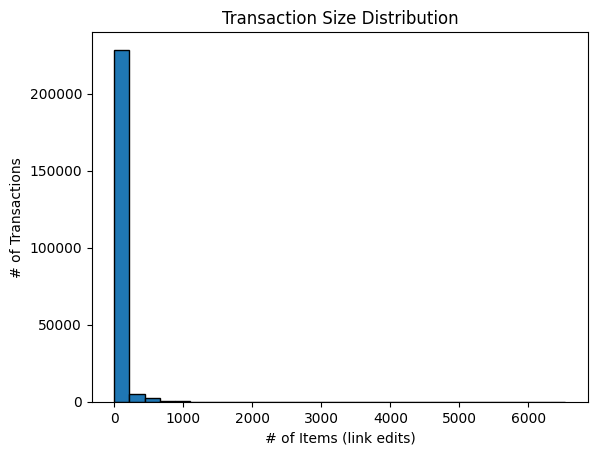

In [4]:


tx = spark.read.parquet("data/transactions_small.parquet")


tx_sizes = tx.withColumn("num_items", size("items"))

# basic stats
tx_sizes.select("num_items").describe().show()

# histogram
import matplotlib.pyplot as plt

sizes = tx_sizes.select("num_items").rdd.flatMap(lambda x: x).collect()
plt.hist(sizes, bins=30, edgecolor="black")
plt.title("Transaction Size Distribution")
plt.xlabel("# of Items (link edits)")
plt.ylabel("# of Transactions")
plt.show()


In [5]:


item_count = (
    tx.select(explode("items").alias("item"))
      .groupBy("item").count()
      .orderBy("count", ascending=False)
)

item_count.show(10)

print(f"Total unique items: {item_count.count()}")


+------------------+-----+
|              item|count|
+------------------+-----+
|   -→215200→604879|   39|
|   +→215200→604879|   37|
|  -→6868638→154028|   33|
|   +→627852→359378|   32|
|  +→6868638→154028|   31|
| -→2935437→2032276|   29|
|   -→627852→359378|   29|
| +→2935437→2032276|   28|
|  +→627852→1445700|   27|
|+→11198015→7264859|   26|
+------------------+-----+
only showing top 10 rows

Total unique items: 4996879


In [7]:

dfs = []
pkl_dir = "data/"
batch_files = [f for f in os.listdir(pkl_dir) if f.startswith("pair_counts_batch_") and f.endswith(".pkl")]

print(f"Found {len(batch_files)} batch files")

for f in batch_files:
    with open(os.path.join(pkl_dir, f), "rb") as handle:
        batch_counter = pickle.load(handle)

    # filter : Keep only pairs occurring >= 3 times in batch
    batch_counter = Counter({pair: cnt for pair, cnt in batch_counter.items() if cnt >= 3})

    rows = [Row(pair=tuple(sorted(k)), count=v) for k, v in batch_counter.items()]

    df = spark.createDataFrame(rows)
    dfs.append(df)

    print(f" Processed batch {f} with {len(rows):,} frequent pairs")

# merge
merged_df = reduce(lambda df1, df2: df1.union(df2), dfs)

# group and sum
pairs_final = merged_df.groupBy("pair").sum("count").withColumnRenamed("sum(count)", "total_count")

# top-20
top20_pairs = pairs_final.orderBy(col("total_count").desc()).limit(100)

print("\n=== Top-20 frequent link pairs ===")
top20_pairs.show(truncate=False)



Found 12 batch files
 Processed batch pair_counts_batch_6.pkl with 12,421 frequent pairs
 Processed batch pair_counts_batch_11.pkl with 883,038 frequent pairs
 Processed batch pair_counts_batch_8.pkl with 51,036 frequent pairs
 Processed batch pair_counts_batch_0.pkl with 33,168 frequent pairs
 Processed batch pair_counts_batch_2.pkl with 66,790 frequent pairs
 Processed batch pair_counts_batch_9.pkl with 40,293 frequent pairs
 Processed batch pair_counts_batch_7.pkl with 39,262 frequent pairs
 Processed batch pair_counts_batch_5.pkl with 25,350 frequent pairs
 Processed batch pair_counts_batch_4.pkl with 329,239 frequent pairs
 Processed batch pair_counts_batch_3.pkl with 94,846 frequent pairs
 Processed batch pair_counts_batch_10.pkl with 93,281 frequent pairs
 Processed batch pair_counts_batch_1.pkl with 133,997 frequent pairs

=== Top-20 frequent link pairs ===


+----------------------------------------+-----------+
|pair                                    |total_count|
+----------------------------------------+-----------+
|{+→215200→604879, -→215200→604879}      |31         |
|{+→11198015→61226, +→11198015→88137}    |23         |
|{+→11198015→196328, +→11198015→88137}   |23         |
|{+→11198015→61226, +→11198015→9829326}  |23         |
|{+→11198015→7264859, +→11198015→9829326}|23         |
|{+→11198015→103140, +→11198015→61226}   |23         |
|{+→11198015→103140, +→11198015→9829326} |23         |
|{+→11198015→7264859, +→11198015→88137}  |23         |
|{+→11198015→61226, +→11198015→7264859}  |23         |
|{+→11198015→196328, +→11198015→61226}   |23         |
|{+→11198015→103140, +→11198015→7264859} |23         |
|{+→11198015→196328, +→11198015→9829326} |23         |
|{+→11198015→88137, +→11198015→9829326}  |23         |
|{+→11198015→103140, +→11198015→88137}   |23         |
|{+→11198015→196328, +→11198015→7264859} |23         |
|{+→111980

In [9]:
top20_pairs.write.mode("overwrite").parquet("data/top100_patterns.parquet")


In [10]:
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import explode, size, udf, col


# new Spark session (different memory config)
spark = (
    SparkSession.builder
      .appName("WiClean+_Reduced_FPGrowth")
      .master("local[*]")
      .config("spark.driver.memory",       "35g")
      .config("spark.driver.maxResultSize","8g")
      .config("spark.sql.shuffle.partitions","100")
      .getOrCreate()
)

# load and sample
tx = (
    spark.read
         .parquet("data/transactions_small.parquet")
         .select("items")
         .filter(size("items") >= 3)
         .filter(size("items") <= 30)
         .sample(False, 0.7, seed=42)
)

# prune items seen >=20 times
item_counts = (
    tx.select(explode("items").alias("item"))
      .groupBy("item").count()
)
min_occ = 5
freq_items = {r.item for r in item_counts.filter(col("count") >= min_occ).collect()}

prune_udf = udf(lambda arr: [x for x in arr if x in freq_items], ArrayType(StringType()))
tx_pruned = (
    tx.withColumn("items", prune_udf("items"))
      .filter(size("items") >= 2)
)

# FPGrowth with min_support
min_support = 0.0001
model = FPGrowth(
    itemsCol="items",
    minSupport=min_support,
    minConfidence=0.0
).fit(tx_pruned)

# save top 2-item patterns
def save_patterns(size_n, topN):
    df = (
        model.freqItemsets
        .filter(size("items") == size_n)
        .orderBy("freq", ascending=False)
        .limit(topN)
        .selectExpr(
            "concat_ws('|', items) AS pattern",
            "cast(freq as string) AS freq"
        )
    )
    out_path = f"data/patterns_size{size_n}_csv_reduced"
    df.rdd.map(lambda row: f"{row.pattern},{row.freq}") \
      .saveAsTextFile(out_path)
    print(f"Saved {topN} patterns of size {size_n} at {out_path}")

save_patterns(size_n=2, topN=1000)
save_patterns(size_n=3, topN=500)

# done
spark.stop()
print("WiClean+ FPGrowth finished successfully with reduced size.")






25/04/28 21:50:45 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Saved 1000 patterns of size 2 at data/patterns_size2_csv_reduced


Saved 500 patterns of size 3 at data/patterns_size3_csv_reduced
WiClean+ FPGrowth finished successfully with reduced size.
